🚀 Using device: cuda

      PART A: TRAINING
🔍 Looking for files: combined_uwb_dataset.csv...
📂 Found 1 files. Combining...
⏳ Processing signals (Smart ROI Backtracking)...

🔥 Starting Training...
Ep 0   | Val Acc: 95.56%
Ep 5   | Val Acc: 97.50%
Ep 10  | Val Acc: 97.22%
Ep 15  | Val Acc: 97.78%
Ep 20  | Val Acc: 97.78%
Ep 25  | Val Acc: 98.61%

✅ Training Complete. Best Acc: 98.61%

      PART B: TESTING
🔍 Looking for files: uwb_dataset_part*.csv...
📂 Found 7 files. Combining...
⏳ Processing signals (Smart ROI Backtracking)...

🏆 Final Accuracy on UNSEEN Data: 76.10%
              precision    recall  f1-score   support

         LOS       0.88      0.60      0.72     21000
        NLOS       0.70      0.92      0.79     21000

    accuracy                           0.76     42000
   macro avg       0.79      0.76      0.75     42000
weighted avg       0.79      0.76      0.75     42000



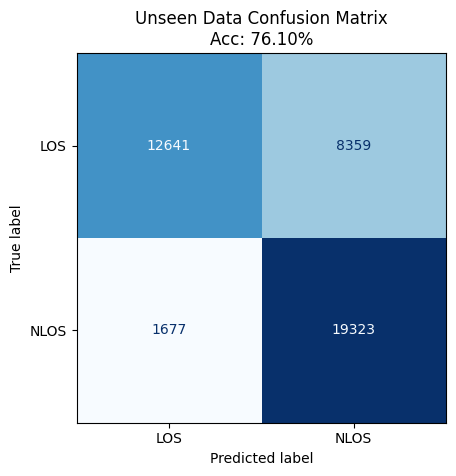

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset

# ==========================================
# 1. SMART ROI ALIGNMENT
# ==========================================
def get_roi_alignment(sig, roi_start=700, roi_end=800):
    """
    Looks strictly within [700, 800] to find the pulse start.
    Backtracks from the Peak to find the Leading Edge.
    """
    # 1. Isolate the User's Known Region
    # Safety: clamp to signal boundaries
    roi_start = max(0, roi_start)
    roi_end = min(len(sig), roi_end)
    
    roi_sig = sig[roi_start:roi_end]
    
    # 2. Find Peak INSIDE the ROI
    local_peak_idx = np.argmax(roi_sig)
    global_peak_idx = roi_start + local_peak_idx
    peak_val = sig[global_peak_idx]
    
    # 3. Define Noise Floor (using silence before the ROI)
    noise_floor = np.mean(sig[0:roi_start]) if roi_start > 0 else 0
    noise_std = np.std(sig[0:roi_start]) if roi_start > 0 else 1
    
    # Threshold: Stop backtracking when signal drops near noise
    # We use a sensitive threshold (Mean + 3*Std) or 10% of peak, whichever is lower
    # This ensures we catch the weak "tail" of the start.
    threshold = max(noise_floor + 3*noise_std, 0.05 * peak_val)
    
    # 4. BACKTRACK from Peak to find Leading Edge
    # We walk backwards from the peak until samples drop below threshold
    scan_idx = global_peak_idx
    while scan_idx > roi_start and sig[scan_idx] > threshold:
        scan_idx -= 1
        
    # scan_idx is now the last point BELOW threshold. 
    # The "Start" is the next point.
    leading_edge = scan_idx
    
    return leading_edge

# ==========================================
# 2. DATA LOADING
# ==========================================
PRE_CROP = 10
POST_CROP = 50
TOTAL_LEN = 60

def load_smart_dataset(file_pattern):
    print(f"🔍 Looking for files: {file_pattern}...")
    files = sorted(glob.glob(file_pattern))
    if not files:
        files = sorted(glob.glob("combined_uwb_dataset.csv"))
    if not files:
        print("❌ No files found.")
        return None, None, None
        
    print(f"📂 Found {len(files)} files. Combining...")
    df_list = [pd.read_csv(f) for f in files]
    df = pd.concat(df_list, ignore_index=True)

    cir_cols = [c for c in df.columns if c.startswith('CIR') and c.replace('CIR', '').isdigit()]
    cir_cols = sorted(cir_cols, key=lambda x: int(x.replace('CIR', '')))
    
    label_col = 'NLOS' if 'NLOS' in df.columns else 'Label'
    rx_col = 'RXPACC' if 'RXPACC' in df.columns else 'RX_PACC'
    
    processed_seqs, context_features, labels = [], [], []
    
    print("⏳ Processing signals (Smart ROI Backtracking)...")
    for _, row in df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        
        # Physics Norm
        rx_val = float(row[rx_col]) if rx_col in row else 128.0
        if rx_val > 0: sig = sig / rx_val
        
        # --- SMART ALIGNMENT ---
        # Look in known region [720, 820] (safe margin around 745)
        align_idx = get_roi_alignment(sig, roi_start=720, roi_end=820)
        
        # Center Crop on that Leading Edge
        start, end = int(align_idx - PRE_CROP), int(align_idx + POST_CROP)
        crop = sig[start:end] if start >= 0 and end <= len(sig) else np.zeros(TOTAL_LEN)
        
        if len(crop) != TOTAL_LEN: 
            temp = np.zeros(TOTAL_LEN)
            if start >= 0 and end <= len(sig): temp = sig[start:end]
            elif start < 0: temp[:min(TOTAL_LEN, len(sig))] = sig[:min(TOTAL_LEN, len(sig))]
            crop = temp
            
        # Instance Norm
        local_min, local_max = np.min(crop), np.max(crop)
        if local_max > local_min:
            crop = (crop - local_min) / (local_max - local_min)
        else:
            crop = np.zeros_like(crop)
            
        processed_seqs.append(crop)
        
        # --- FEATURES ---
        c_max = np.max(sig) 
        total_energy = np.sum(sig**2) + 1e-9
        
        # Energy at the Leading Edge vs Total
        # In NLOS, the leading edge is weak, so this ratio is SMALL.
        le_energy = np.sum(sig[align_idx:align_idx+5]**2)
        c_pow_ratio = le_energy / total_energy
        
        # Rise Time: Distance from Leading Edge to the Peak inside the crop
        crop_peak_idx = np.argmax(crop) # Peak position relative to crop start
        # Since we centered crop such that align_idx is at PRE_CROP (index 10),
        # The rise time is simply (Peak Index - 10)
        rise_time = max(0, crop_peak_idx - PRE_CROP)
        
        context_features.append([c_max, total_energy, c_pow_ratio, rise_time])
        labels.append(float(row[label_col]))
        
    X_seq = np.array(processed_seqs).reshape(-1, TOTAL_LEN, 1)
    X_ctx = np.array(context_features)
    y = np.array(labels)
    
    return X_seq, X_ctx, y

# ==========================================
# 3. LIQUID NEURAL NETWORK
# ==========================================
class LiquidCell(nn.Module):
    def __init__(self, input_size, hidden_size, context_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.synapse = nn.Linear(input_size + hidden_size, hidden_size)
        self.A = nn.Parameter(torch.ones(hidden_size) * -0.5)
        self.tau_controller = nn.Sequential(
            nn.Linear(context_size, 32), nn.Tanh(),
            nn.Linear(32, hidden_size), nn.Sigmoid())
        
    def forward(self, x_t, h_prev, context, dt=1.0):
        tau_gate = self.tau_controller(context)
        tau = 1.0 + (4.0 * tau_gate) 
        combined = torch.cat((x_t, h_prev), dim=1)
        S_t = torch.tanh(self.synapse(combined))
        h_new = (h_prev + (dt * S_t * self.A)) / (1.0 + (dt / tau))
        return h_new, tau

class PureLNN(nn.Module):
    def __init__(self, context_size=4):
        super().__init__()
        self.hidden_size = 128 
        self.cell = LiquidCell(1, self.hidden_size, context_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 64), nn.SiLU(), 
            nn.Dropout(0.4), nn.Linear(64, 1), nn.Sigmoid())
        
    def forward(self, x_seq, x_ctx):
        batch_size, seq_len, _ = x_seq.size()
        h_t = torch.zeros(batch_size, self.hidden_size).to(x_seq.device)
        for t in range(seq_len):
            h_t, _ = self.cell(x_seq[:, t, :], h_t, x_ctx)
        return self.classifier(h_t)

# ==========================================
# 4. MAIN
# ==========================================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Using device: {device}")

    # --- TRAIN ---
    print("\n" + "="*40 + "\n      PART A: TRAINING\n" + "="*40)
    X_seq_all, X_ctx_all, y_all = load_smart_dataset("combined_uwb_dataset.csv")
    if X_seq_all is None: return

    scaler = StandardScaler()
    X_ctx_all = scaler.fit_transform(X_ctx_all)
    num_features = X_ctx_all.shape[1]
    
    X_tr, X_va, C_tr, C_va, y_tr, y_va = train_test_split(X_seq_all, X_ctx_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
    
    # Tensors
    tr_ds = TensorDataset(torch.tensor(X_tr).float().to(device), torch.tensor(C_tr).float().to(device), torch.tensor(y_tr).float().unsqueeze(1).to(device))
    va_ds = TensorDataset(torch.tensor(X_va).float().to(device), torch.tensor(C_va).float().to(device), torch.tensor(y_va).float().unsqueeze(1).to(device))
    train_loader = DataLoader(tr_ds, batch_size=32, shuffle=True)

    model = PureLNN(context_size=num_features).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-4)
    
    best_acc = 0.0
    print("\n🔥 Starting Training...")
    
    for epoch in range(30):
        model.train()
        for bx, bctx, by in train_loader:
            optimizer.zero_grad()
            preds = model(bx, bctx)
            loss = nn.BCELoss()(preds, by)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            bx, bctx, by = next(iter(DataLoader(va_ds, batch_size=len(va_ds)))) # Full batch val
            val_preds = model(bx, bctx)
            val_acc = ((val_preds > 0.5).float() == by).float().mean().item()
        
        if epoch % 5 == 0: print(f"Ep {epoch:<3} | Val Acc: {100*val_acc:.2f}%")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_lnn_smart.pt")

    print(f"\n✅ Training Complete. Best Acc: {100*best_acc:.2f}%")

    # --- TEST ---
    print("\n" + "="*40 + "\n      PART B: TESTING\n" + "="*40)
    X_unseen, X_ctx_unseen, y_unseen = load_smart_dataset("uwb_dataset_part*.csv")
    if X_unseen is None: return

    X_ctx_unseen = scaler.transform(X_ctx_unseen) # Use training scaler!

    model.load_state_dict(torch.load("best_lnn_smart.pt", map_location=device))
    model.eval()
    
    # Fixed DataLoader
    test_ds = TensorDataset(torch.tensor(X_unseen).float(), torch.tensor(X_ctx_unseen).float(), torch.tensor(y_unseen).float().unsqueeze(1))
    test_loader = DataLoader(test_ds, batch_size=64)
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for bx, bctx, by in test_loader:
            bx, bctx = bx.to(device), bctx.to(device)
            preds = model(bx, bctx)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(by.numpy().flatten())
            
    y_pred = (np.array(all_preds) > 0.5).astype(int)
    y_true = np.array(all_targets)
    acc = (y_pred == y_true).mean()
    
    print(f"\n🏆 Final Accuracy on UNSEEN Data: {100*acc:.2f}%")
    print(classification_report(y_true, y_pred, target_names=['LOS', 'NLOS']))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['LOS', 'NLOS'])
    disp.plot(cmap='Blues', colorbar=False)
    plt.title(f"Unseen Data Confusion Matrix\nAcc: {100*acc:.2f}%")
    plt.show()

if __name__ == "__main__":
    main()